1980년도 이전에는 주로 소벨 마스크가 에지 연산자로 사용되었다. 그런 상황에서 1980년에 Marr와 Hildreth가 발표한 논문은 에지 검출에 새로운 물줄기를 만들었다.

### 가우시안과 다중 스케일 효과

Marr와 Hildreth는 1차 미분 대신 2차 미분을 사용하는데, 미분을 적용하기 전에 가우시안으로 스무딩하는 전처리 과정을 중요하게 생각하였다.  
가우시안 스무딩은 다음의 두 가지 효과를 제공한다.

- 잡음에 대처한다.
- 가우시안의 매개변수 sigma값을 조절해 다중 스케일(multi-scale) 효과를 얻는다.

![](./data/edge_multi_scale.jpg)

sigma=0.5일 때 1차 미분과 2차 미분 결과를 보면 1차와 2차 미분 모두에서 영교차가 선명하게 나타난다.  
반면 sigma가 커짐에 따라 폭이 작은 물체의 에지는 약해지는 것을 알 수 있다.  
위의 사진을 통해 알 수 있는 것은 가우시안의 sigma를 조절해 스무딩 정도를 조절할 수 있으며 이는 에지 스케일을 정해준다는 것이다.

다음의 가우시안식을 보며 이산 공간에서 어떻게 구현할지 생각해보자
$$
G(x)=\frac{1}{\sqrt{2 \pi} \sigma}e^{-\frac{x^{2}}{2 \sigma^{2}}}
$$



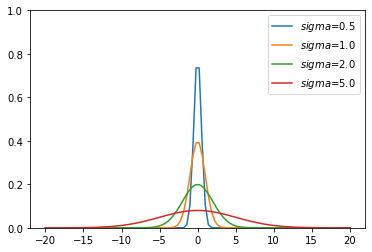

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

x = np.linspace(-20,20,100)
def gaussian(x,sigma):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-1*((x**2)/(2*(sigma**2))))

plt.plot(x,gaussian(x,0.5))
plt.plot(x,gaussian(x,1.0))
plt.plot(x,gaussian(x,2.0))
plt.plot(x,gaussian(x,5.0))
plt.ylim(0,1)
plt.legend(['$sigma$=0.5','$sigma$=1.0','$sigma$=2.0','$sigma$=5.0'])
plt.show()

위 식에서 x가 0인 점에서 멀어지면 G(.)는 점점 작아지고, x의 크기가 크면 0에 아주 가까워진다. 따라서 샘플링할 때 적절한 크기의 마스크를 사용해야 한다. 만약 $$\sigma=2.0$$인 경우, 눈대중으로 짐작할 때 x는 절대값이 6일 때 0에 가까우므로 크기가 13정도인 마스크를 만들어 적용한다. 이것보다 작은 마스크는 오차가 커서 영상처리의 품질이 떨어지고, 크면 시간 효율만 나빠지고 크게 얻는 것이 없다.

### LOG 필터
먼저 라플라시안(Laplacian)에 대해 설명한다.  
라플라시안은 y와 x의 2차 편도함수를 더한 것으로 다음과 같이 정의할 수 있다.
$$
\Delta^{2}f(y,x)=\frac{\partial^{2}f}{\partial y^{2}}+\frac{\partial^{2}f}{\partial x^{2}}
$$
이를 이산 공간에서 전개하면 다음과 같이 된다.
$$
\Delta^{2}f(y,x)=\frac{\partial^2 f}{\partial y^{2}}+\frac{\partial^{2}f}{\partial x^{2}} \\
=(f(y+1,x)+f(y-1,x)-2f(y,x)) + (f(y,x+1)+f(y,x-1)-2f(y,x))\\
=f(y+1,x)+f(y-1,x)+f(y,x+1)+f(y,x-1)-4f(y,x) \\
이에 \ 해당하는 \ 필터 : \begin{pmatrix} 0&1&0 \\ 1&-4&1\\0&1&0 \end{pmatrix}
$$
LOG 필터는 가우시안을 이산 필터로 근사화 한 후 라플라시안을 이산 필터로 근사화 하는 방식이다.  
하지만 컨볼루션을 두 번 수행하기 때문에 계산 효율이 낮다.  
이에 대한 대안으로 가우시안과 라플라시안의 연속 함수를 하나로 함치는 것이다.

입력 영상 f를 가우시안으로 컨볼루션한 후 라플라시안을 취하면 컨볼루션과 라플라시안 연산 간 결합법칙이 성립한다. 따라서 G에 라플라시안을 취한 후 그 결과를 f와 컨볼루션을 한 것과 같다.  
이 식에서 가우시안에 라플라시안을 적용해 $$\Delta^{2}G$$를 LOG(Laplacian of Gaussian) 연산자 또는 LOG 필터라 부른다.
$$
LOG(y,x) = \Delta^{2}(G(y,x)\circledast f(y,x))=(\Delta^{2}G(y,x)) \circledast f(y,x)
$$
이 식을 좀 더 전개 해보자면 다음과 같다.
$$
\Delta^{2}G(y,x)= \frac{\partial^2 G(y,x)}{\partial y^{2}}+\frac{\partial^2 G(y,x)}{\partial x^{2}}=\frac{\partial}{\partial y} \left( \frac{\partial G(y,x)}{\partial y} \right) + \frac{\partial}{\partial x} \left( \frac{\partial G(y,x)}{\partial x} \right) \\
=\frac{\partial}{\partial y} \left( -\left( \frac{y}{\sigma^{2}} \right)  \frac{1}{2\pi \sigma^{2}} e^{-\frac{y^{2}+x^{2}}{2\sigma^{2}}} \right) + \frac{\partial}{\partial x} \left( -\left( \frac{x}{\sigma^{2}} \right)  \frac{1}{2\pi \sigma^{2}} e^{-\frac{y^{2}+x^{2}}{2\sigma^{2}}} \right) \\
= \left( \frac{y^{2}}{\sigma^{4}}-\frac{1}{\sigma^2} \right) \frac{1}{2 \pi \sigma^{2}}e^{-\frac{y^{2}+x^{2}}{2\sigma^{2}}} + \left( \frac{x^{2}}{\sigma^{4}}-\frac{1}{\sigma^2} \right) \frac{1}{2 \pi \sigma^{2}}e^{-\frac{y^{2}+x^{2}}{2\sigma^{2}}} \\ = \left( \frac{y^{2}+x^{2}-2 \sigma^{2}}{\sigma^{4}} \right)G(y,x) \\
\therefore \Delta^{2}G(y,x)=\frac{y^{2}+x^{2}-2 \sigma^{2}}{\sigma^{4}}G(y,x)
$$



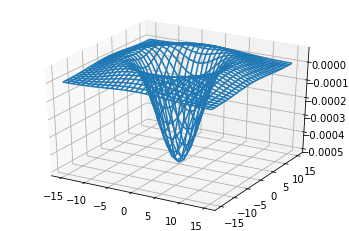

array([[ 5.02816777e-07,  8.32941456e-07,  1.32531170e-06,
         2.02627092e-06,  2.97833813e-06,  4.21132411e-06,
         5.73268187e-06,  7.51927384e-06,  9.51293136e-06,
         1.16215851e-05,  1.37264329e-05,  1.56940152e-05,
         1.73908077e-05,  1.86975374e-05,  1.95209844e-05,
         1.98021792e-05,  1.95209844e-05,  1.86975374e-05,
         1.73908077e-05,  1.56940152e-05,  1.37264329e-05,
         1.16215851e-05,  9.51293136e-06,  7.51927384e-06,
         5.73268187e-06,  4.21132411e-06,  2.97833813e-06,
         2.02627092e-06,  1.32531170e-06,  8.32941456e-07,
         5.02816777e-07],
       [ 8.32941456e-07,  1.37137893e-06,  2.16750916e-06,
         3.28999794e-06,  4.79826635e-06,  6.72840120e-06,
         9.07892719e-06,  1.18001654e-05,  1.47908031e-05,
         1.79037950e-05,  2.09611259e-05,  2.37742331e-05,
         2.61652222e-05,  2.79842349e-05,  2.91203896e-05,
         2.95065608e-05,  2.91203896e-05,  2.79842349e-05,
         2.61652222e-05,  2.37

In [2]:
def gaussian2d(x,y,sigma):
    x2 = x**2
    y2 = y**2
    sigma2 = sigma**2
    return (1/(2*np.pi*sigma2))*np.exp(-1*((x2+y2)/(2*sigma2)))


def LOG(sigma,plot=False):
    size = int(sigma * 6)
    if  size %2 == 0:
        size+=1
    aran = np.arange(-1*(size//2),size//2+1)
    XX, YY = np.meshgrid(aran,aran)
    xx2 = XX**2
    yy2 = YY**2
    sigma2 = sigma**2
    log = ((xx2+yy2-(2*sigma2))/(sigma2**2)) * gaussian2d(XX,YY,sigma)
    if plot:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_wireframe(XX, YY, log)
        plt.show()
    return log

LOG(5.0,True)

LOG 필터의 모양을 보면 방향과 무관한 등방성(isotropic) 성질을 가진다. 이는 사람의 시각과 비슷한 성질이다.  
멕시코 모자(Mexican hat)라는 별명으로 불리기도 하고 밀짚모자라고 부르는 사람도 있는 것 같다.  
이산 공간에서 근사화 할 때 필터의 크기는 6xsigma와 같거나 그것보다 큰 정수 중에 가장 작은 홀수를 필터의 크기로 취한다. 예를들어 \sigma=0.5일 때는 3x3 이다.

### 영교차 검출
이론적으로는 결과 영상을 $$g$$라고 했을 때, $$g(j,i)=0$$인 화소 중에서 마주보는 이웃이 서로 다른 부호를 가진 것을 영교차 점으로 보고 $$b(j,i)=1$$로 설정하면 된다. 하지만 연속 공간을 이산 공간으로 근사화했을 뿐 아니라 잡음의 영향이 있어 현실적인 규칙을 적용해야한다. 규칙은 다음과 같다.

- 여덟 개의 이웃 중에 마주보는 동-서, 남-북, 북동-남서, 북서-남동의 화소 쌍 네 개를 조사한다. 그들 중 두 개 이상이 서로 다른 부호를 가진다.
- 부호가 다른 쌍의 값 차이가 임계값을 넘는다.

구현하면 다음과 같다.

In [3]:
def im2col(input_data, filter_h, filter_w):
    H, W, C = input_data.shape

    u_pad_h = (filter_h-1)//2
    d_pad_h = (filter_h-1)//2
    l_pad_w = (filter_w-1)//2
    r_pad_w = (filter_w-1)//2
    if (filter_h-1) %2 ==1:
        u_pad_h +=1
    if (filter_w-1)%2 ==1:
        l_pad_w +=1
    input_data = cv2.copyMakeBorder(input_data, u_pad_h, d_pad_h, l_pad_w, r_pad_w, cv2.BORDER_REPLICATE)
    if C==1:
        input_data= np.expand_dims(input_data,-1)
    img = np.transpose(input_data,(2,0,1))
    col = np.zeros(( C, filter_h, filter_w, H, W))

    for y in range(filter_h):
        y_max = y + H
        for x in range(filter_w):
            x_max = x + W
            col[:, y, x, :, :] = img[:, y:y_max:1, x:x_max:1]

    col = np.transpose(col,(0,3,4,1,2)).reshape(C*H*W, -1)

    return col

def conv(img,filter):
    filter_h ,filter_w = filter.shape
    if len(img.shape) ==3:
        img_h,img_w,c = img.shape
    elif len(img.shape)==2:
        img_h,img_w = img.shape
        c=1
        img = np.expand_dims(img,-1)
    else:
        print("Length of image shape must over 2")
        return
    col = im2col(img,filter_h,filter_w)
    col_filetr = filter.reshape((1,-1)).T
    out = np.dot(col, col_filetr)
    return np.transpose(out.reshape((c, img_h, img_w)),(1, 2,0))


sigma 값을 다르게 하면 다음과 같다. 임계값은 영상 g의 최대값에 0.05를 곱했다.

In [4]:
def sign(a,b):
    sign1 = np.logical_and(a<0,b>0)
    sign2 = np.logical_and(b<0,a>0)
    return np.logical_or(sign1,sign2)


def LOG_conv(img,filter,threshold=None):
    log_img=conv(img,filter).squeeze()
    if threshold == None:
        threshold = np.max(log_img)*0.05
    w_img = np.pad(log_img[:,1:],((0,0),(0,1)))
    e_img = np.pad(log_img[:,:-1],((0,0),(1,0)))
    n_img = np.pad(log_img[:-1,:],((1,0),(0,0)))
    s_img = np.pad(log_img[1:, :], ((0,1), (0, 0)))
    sw_img = np.pad(s_img[:,1:],((0,0),(0,1)))
    nw_img = np.pad(n_img[:, 1:], ((0, 0), (0, 1)))
    se_img = np.pad(s_img[:,:-1],((0,0),(1,0)))
    ne_img = np.pad(n_img[:,:-1], ((0, 0), (1, 0)))

    w_vs_e = np.int8(np.logical_and(np.absolute(w_img-e_img)>threshold,sign(w_img,e_img)))
    s_vs_n = np.int8(np.logical_and(np.absolute(n_img - s_img) > threshold,sign(n_img,s_img)))
    sw_vs_ne = np.int8(np.logical_and(np.absolute(sw_img - ne_img) > threshold,sign(sw_img,ne_img)))
    nw_vs_se = np.int8(np.logical_and(np.absolute(nw_img - se_img) > threshold,sign(nw_img,se_img)))

    return np.uint8(w_vs_e+s_vs_n+sw_vs_ne+nw_vs_se>=1)*255

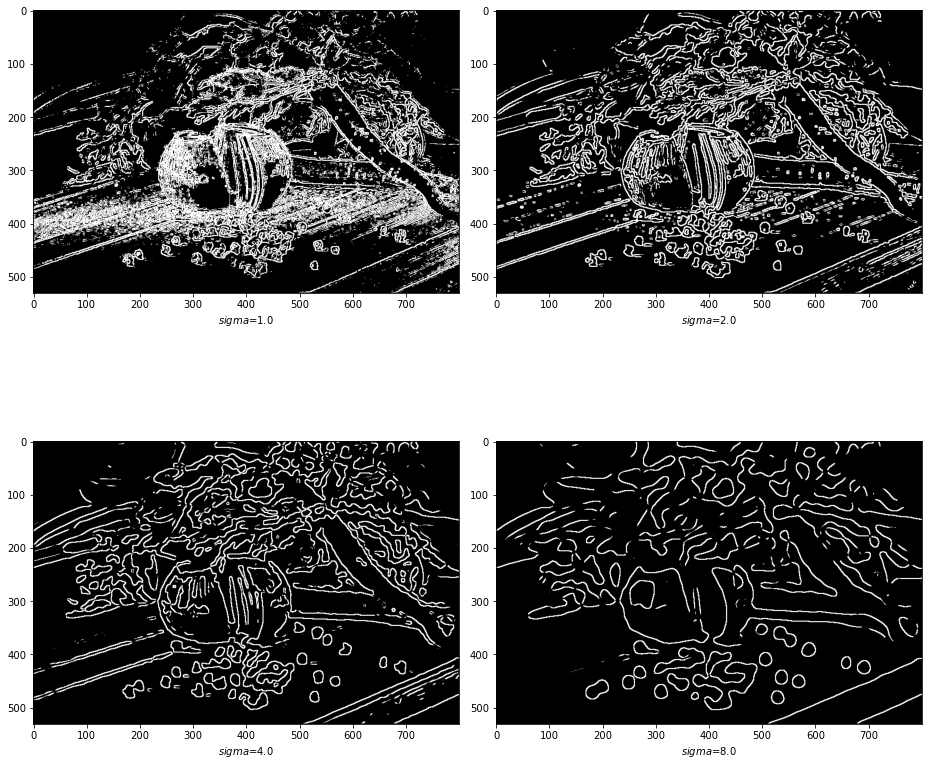

In [5]:
img = cv2.imread('./data/food.jpg',cv2.IMREAD_GRAYSCALE)

sigma_value = [1.0,2.0,4.0,8.0]
fig = plt.figure(figsize=(13,13))
for i in range(1,5):
    plt.subplot(220+i)
    log_filter = LOG(sigma_value[i-1])
    log_img = LOG_conv(img,log_filter)
    plt.imshow(log_img,cmap='gray')
    plt.xlabel('$sigma$={}'.format(sigma_value[i-1]))
fig.tight_layout()
plt.show()

결과를 보면 \sigma가 작을 때에는 세밀한 에지까지 검출되는 반면, 커지면 세밀한 부분은 점점 사라지고 큰 규모의 에지만 남는다.